# XGBoost para classificação da direção de criptos

In [325]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [326]:
# Leitura dos dados
symbol = 'BTCUSDT'
period = '5m'
df = pd.read_csv(f'../../data/fechamentos/{symbol}_{period}_data.csv')

df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

In [327]:
# Preparação dos dados para classificação
df['target'] = np.where(df['close'].shift(-1) > df['close'], 1, 0)  # 1 para alta, 0 para baixa
df.dropna(inplace=True) 

# Construção das features
def create_features(df):
    df = df.copy()
    epsilon = 1e-10  # Para evitar divisão por zero em contas com divisão

    df['return'] = df['close'].pct_change()
    df['volatility'] = df['return'].rolling(window=5).std()

    df['momentum_5'] = df['close'].diff(5)
    df['momentum_10'] = df['close'].diff(10)
    df['momentum_20'] = df['close'].diff(20)

    def williams_r(high, low, close, period=14):
        highest_high = high.rolling(window=period).max()
        lowest_low = low.rolling(window=period).min()
        return ((highest_high - close) / (highest_high - lowest_low + epsilon)) * -100
    df['williams_r'] = williams_r(df['high'], df['low'], df['close'])

    def rsi(close, period=14):
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)

        avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()

        rs = avg_gain / (avg_loss + epsilon)
        return 100 - (100 / (1 + rs))
    df['rsi_7'] = rsi(df['close'], period=7)
    df['rsi_14'] = rsi(df['close'], period=14)

    df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema_12'] - df['ema_26']
    
    df['price_change'] = df['close'].diff()
    df['price_trend'] = df['close'].rolling(window=10).mean()

    df['volume_change'] = df['volume'].pct_change()
    df['volume_trend'] = df['volume'].rolling(window=10).mean()
    
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    
    df.dropna(inplace=True)
    return df

# Aplicação da função
df = create_features(df)
df = df.drop(columns=['open', 'high', 'low', 'volume'])

In [328]:
# Divisão dos dados em treino e teste
tsv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tsv.split(df):
    X_train, X_test = df.iloc[train_index].drop(columns=['target']), df.iloc[test_index].drop(columns=['target'])
    y_train, y_test = df.iloc[train_index]['target'], df.iloc[test_index]['target']


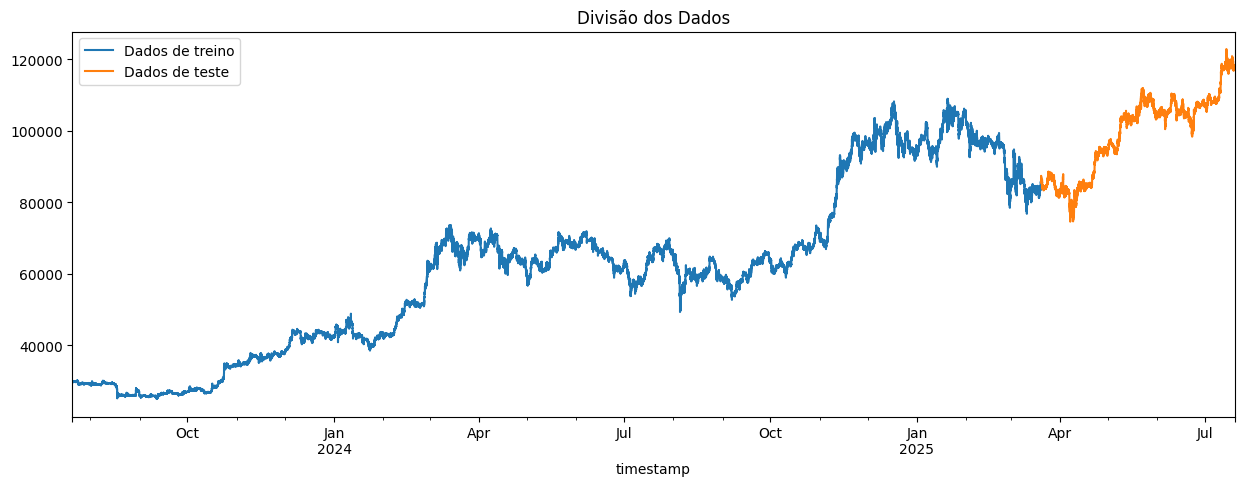

In [329]:
# Visualização da divisão dos dados
fig, ax = plt.subplots(figsize=(15, 5))
X_train['close'].plot(ax=ax, label='Dados de treino', title='Divisão dos Dados')
X_test['close'].plot(ax=ax, label='Dados de teste')
ax.legend(['Dados de treino', 'Dados de teste'])
plt.show()

In [ ]:
# Criação do modelo XGBoost
model = xgb.XGBClassifier(n_estimators=10000, objective='binary:logistic', learning_rate=0.001, max_depth=7, early_stopping_rounds=10, random_state=1)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

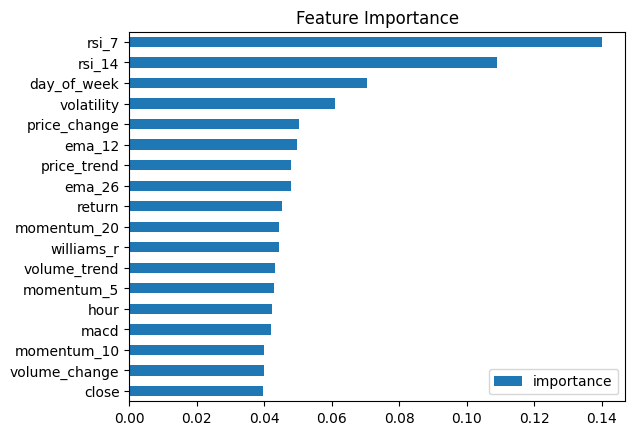

In [ ]:
# Visualização da importância das features
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
# Visualização da matriz de confusão
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Acurácia: {acc*100:.2f}%')

prec = precision_score(y_test, y_pred)
print(f'Precisão: {prec*100:.2f}%')

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1*100:.2f}%')

recall = recall_score(y_test, y_pred)
print(f'Recall: {recall*100:.2f}%')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixa', 'Alta'], yticklabels=['Baixa', 'Alta'])
plt.title('Matriz de Confusão')

Acurácia: 51.37%
Precisão: 51.41%
F1 Score: 50.42%
Recall: 49.46%


Text(0.5, 1.0, 'Matriz de Confusão')

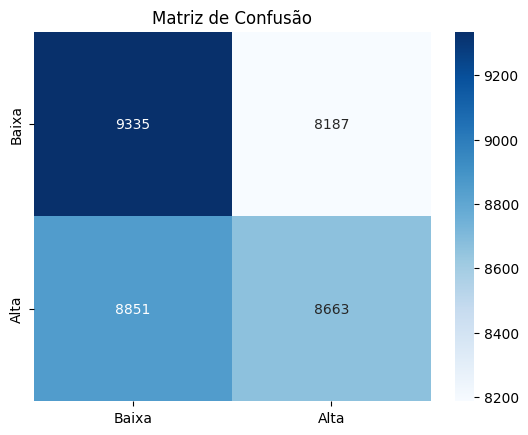

In [333]:
# Visualização da matriz de confusão
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Acurácia: {acc*100:.2f}%')

prec = precision_score(y_test, y_pred)
print(f'Precisão: {prec*100:.2f}%')

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1*100:.2f}%')

recall = recall_score(y_test, y_pred)
print(f'Recall: {recall*100:.2f}%')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixa', 'Alta'], yticklabels=['Baixa', 'Alta'])
plt.title('Matriz de Confusão')